# Predicting the price of Spanish red wines
Author: Kostas Batsis

This project concerns a linear regression model for the prediction of the price of Spanish red wines. It is based on a dataset obtained from kaggle (https://www.kaggle.com/datasets/fedesoriano/spanish-wine-quality-dataset) which was created from web scrapings of various sites, from wine specialized pages to supermarkets.

A description by the dataset creator of the included variables follows:

__winery__: Winery name <br>
__wine__: Name of the wine <br>
__year__: Year in which the grapes were harvested <br>
__rating__: Average rating given to the wine by the users [from 1-5] <br>
__num_reviews__: Number of users that reviewed the wine <br>
__country__: Country of origin [Spain] <br>
__region__: Region of the wine <br>
__price__: Price in euros [€] <br>
__type__: Wine variety <br>
__body__: Body score, defined as the richness and weight of the wine in your mouth [from 1-5] <br>
__acidity__: Acidity score, defined as wine's “pucker” or tartness; it's what makes a wine refreshing and your tongue salivate and want another sip [from 1-5]

In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import miceforest as mf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error

I first read the dataset into a pandas dataframe.

In [2]:
spanishWines = pd.read_csv('wines_SPA.csv')

I then examined descriptives of the numerical variables, a few sample rows, the data types of the columns and I searched for missing data. After these steps I also shuffled the data.

            rating   num_reviews        price         body      acidity
count  7500.000000   7500.000000  7500.000000  6331.000000  6331.000000
mean      4.254933    451.109067    60.095822     4.158427     2.946612
std       0.118029    723.001856   150.356676     0.583352     0.248202
min       4.200000     25.000000     4.990000     2.000000     1.000000
25%       4.200000    389.000000    18.900000     4.000000     3.000000
50%       4.200000    404.000000    28.530000     4.000000     3.000000
75%       4.200000    415.000000    51.350000     5.000000     3.000000
max       4.900000  32624.000000  3119.080000     5.000000     3.000000



                winery                                wine  year  rating  \
4606     Mar de Frades  Rias Baixas Albarino Finca Valinas  2015     4.2   
1256  Bodegas Faustino                      I Gran Reserva  1964     4.3   
3912            Lustau           Candela Cream Dulce Sweet  N.V.     4.2   
2286    Ramon do Casar                       

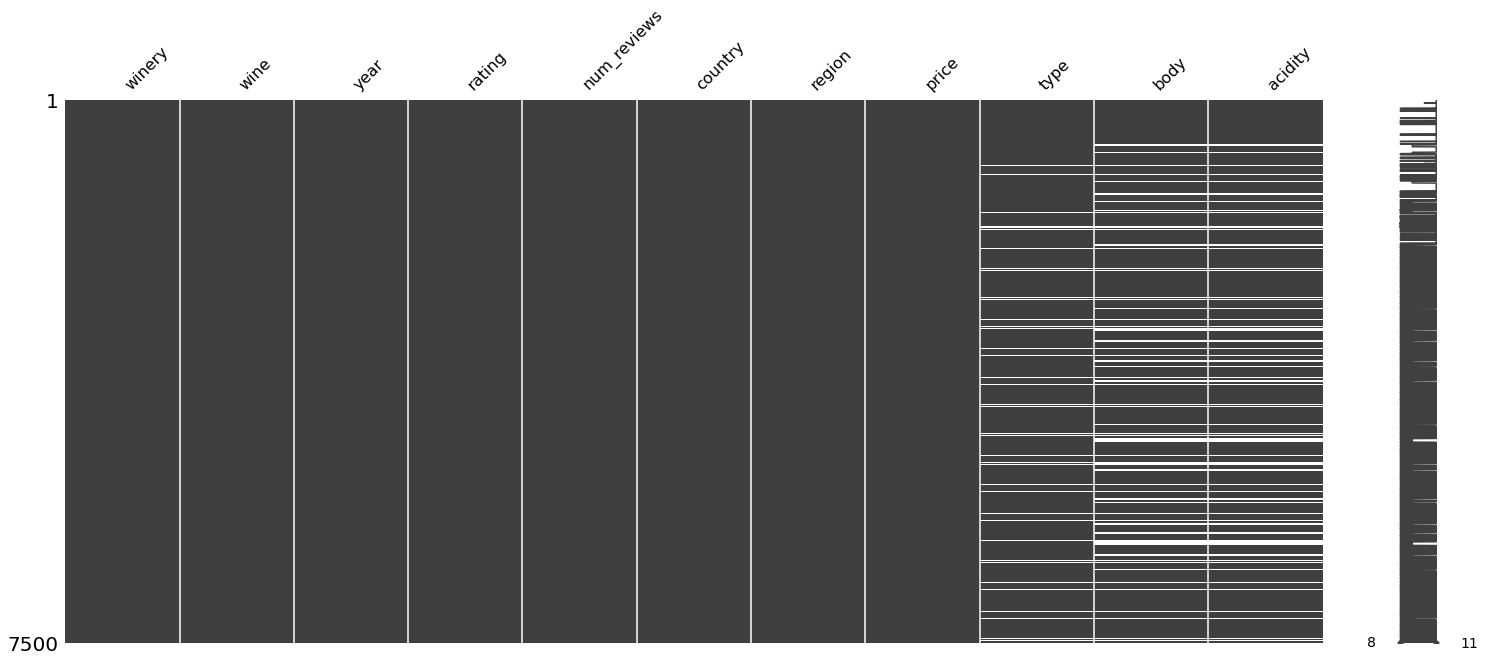

In [3]:
print(spanishWines.describe())
print('\n\n')
print(spanishWines.sample(5,random_state=3))
print('\n\n')
print(spanishWines.dtypes)
print('\n\n')
print('Missing data\n',spanishWines.isnull().sum(),'\n')
msno.matrix(spanishWines)
spanishWines = spanishWines.sample(frac=1,random_state=1)

No outliers or otherwise unreasonable values appear in the descriptives. Note that year is missing, since it is assigned an object type, I will explore this issue below.

The target variable (i.e., price) is very skewed due to the inclusion of some quite expensive wines. To improve the perfomance of the model and the conformation of the data to the linear regression assumptions I decided to limit the data to wines with a price below or equal to 100€. Thus I limited the model to the prediction of mass consumption wines to the exclusion of more luxury ones (see below).

For the missing data analysis we see that ```year``` has only two rows with missing data but ```type```, ```body``` and ```acidity``` have a significant amount of missing data (7.3%, 15.6% and 15.6% respectively). Keeping in mind that the data were scraped and the distribition of the missing data on the graph above it is reasonable to conclude that missingness on the latter variables is due to some websites not including this kind of more secondary information. Note especially that many rows miss data on two or all three of the involved columns and that ```body``` and ```acidity``` have a higher number of missing data since these are even more specialized types of information than wine ```type```. Since removing data from whole websites may introduce bias in the model I finally imputed these data (see below). We should keep in mind though that the missingness may be related to the type of website/store (e.g., less specialized sites may be the ones not including the missing information) and since this is an unobserved variable some bias might still exist in the model even with imputation.

Moving on I removed the luxury wines.

In [4]:
spanishWines = spanishWines[spanishWines['price']<=100]
print(spanishWines.describe())

            rating   num_reviews        price         body      acidity
count  6962.000000   6962.000000  6962.000000  5807.000000  5807.000000
mean      4.233352    450.946280    34.622406     4.134321     2.954021
std       0.081411    689.523568    20.568057     0.577633     0.220670
min       4.200000     25.000000     4.990000     2.000000     1.000000
25%       4.200000    390.000000    18.900000     4.000000     3.000000
50%       4.200000    404.000000    28.300000     4.000000     3.000000
75%       4.200000    415.000000    48.960000     4.000000     3.000000
max       4.700000  32624.000000   100.000000     5.000000     3.000000


Note that after the removal of the expensive wines the majority of data still remain in the dataset.

For the next step I explored in greater detail the ```year``` variable.

In [5]:
pd.set_option("display.max_rows",1000)

print(spanishWines['year'].unique())
print('\n')
print(spanishWines['year'].value_counts())

['2019' '2014' '2015' '2012' '2018' '2011' '2017' 'N.V.' '2006' '2020'
 '2016' '2004' '2010' '2005' '1994' '2008' '2007' '2013' '1996' '2000'
 '2009' '2001' '1985' '1998' '1988' '2021' '2002' '2003' nan '1964' '1995'
 '1999' '1990' '1987' '1978' '1986' '1970']


2011    1161
2016     859
2018     835
2015     830
2017     706
2012     504
2020     473
2014     342
2019     327
N.V.     275
2004     231
2005     179
2010      48
2013      46
2009      29
2006      20
2007      20
2008      19
2000       9
2021       6
1994       6
2001       5
2002       5
1998       4
2003       4
1985       3
1999       3
1995       3
1996       2
1964       1
1988       1
1990       1
1987       1
1978       1
1986       1
1970       1
Name: year, dtype: int64


We see that there is a category for non-vintage wines which is the reason for the assignment of the object type to the variable. Since all recent years are represented in the dataset I decided to keep the variable as is.

Note also that older years have a very low number of data included. Since I eventually used Lasso regression, any non-relevant categories were excluded automatically by the model.

Finally I removed the few missing data from the year variable.

In [6]:
spanishWines = spanishWines.dropna(subset='year')

I then procedeed to examine the rest of the categorical variables. We see that the ```country``` variable has only one category and that in ```type``` two white types of wine are included (Rioja White and Sauvignon Blanc). These data were removed. The low counts of data for some categories were again taken care of by the penalty of the Lasso regression.

In [7]:
for name in ['winery','wine','country','region','type']:
    print('**',name,'**','\n',spanishWines[name].value_counts(),'\n')

** winery ** 
 Contino                                             455
La Rioja Alta                                       240
Sierra Cantabria                                    233
Artadi                                              231
Matarromera                                         230
Imperial                                            227
Losada                                              227
Ramon Bilbao                                        225
Vina Pedrosa                                        225
Portal del Priorat                                  225
Sei Solo                                            225
Matsu                                               224
Conreria d'Scala Dei                                223
Lustau                                              223
La Vicalanda                                        223
Campillo                                            223
Bodegas La Horra                                    223
Mustiguillo                      

 Reserva                                                                   466
Gran Reserva                                                              451
Rioja Reserva                                                             238
El Viejo                                                                  224
Corimbo I                                                                 223
Mirto                                                                     223
Valdegines                                                                223
Rioja Graciano                                                            223
Preludio                                                                  222
Coleccion Privada                                                         222
Altos de Losada                                                           222
Clos del Portal Somni                                                     222
Vina Alberdi Crianza                                           

In [8]:
spanishWines = spanishWines.drop('country',axis=1)
spanishWines = spanishWines[spanishWines.type != 'Rioja White']
spanishWines = spanishWines[spanishWines.type != 'Sauvignon Blanc']

Next I proceded with the imputation of the missing data. For the ```type``` variable I simply imputed the generic and third more frequent category ```Red``` in the missing rows.

In [9]:
imputerForType = SimpleImputer(strategy='constant',fill_value='Red')
imputedType = imputerForType.fit_transform(spanishWines['type'].to_numpy().reshape(-1, 1))
spanishWines['type'] = imputedType

print(spanishWines['type'].sample(5),'\n')

1122    Ribera Del Duero Red
2137                  Sherry
4143               Rioja Red
4575               Rioja Red
5739                     Red
Name: type, dtype: object 



For the ```body``` and ```acidity``` variables I used multivariate imputation with the ```miceforest``` package for estimating the missing data. Miceforest uses the MICE algorithm with the LightGBM gradient-boosting framework and Predictive Mean Matching for the estimation. It also handles categorical data automatically.

After the imputation completed I also converted all the categorical variables in the dataset to One Hot encoded ones.

In [10]:
for column in ['winery','wine','year','region','type']:
    spanishWines[column] = spanishWines[column].astype('category')
    
kernel = mf.ImputationKernel(spanishWines,variable_schema=['body','acidity'],random_state=23)
kernel.mice(10)
spanishWines = kernel.complete_data()

print(spanishWines.sample(5),'\n')
print(spanishWines[['body','acidity']].describe(),'\n')
print('Missing data\n',spanishWines.isnull().sum(),'\n')
spanishWines = pd.get_dummies(spanishWines,drop_first=False)

C:\Users\kostas\anaconda3\lib\site-packages\miceforest\ImputationKernel.py:369: UserWarning: [winery,wine,year,region,type] have very rare categories, it is a good idea to group these, or set the min_data_in_leaf parameter to preventlightgbm from outputting 0.0 probabilities.
  warn(


                    winery               wine  year  rating  num_reviews  \
5050          La Vicalanda            Reserva  2015     4.2          420   
1717       Telmo Rodriguez        Molino Real  2015     4.3           38   
2104              Imperial      Rioja Reserva  2004     4.2          417   
3095  Conreria d'Scala Dei      Les Brugueres  2018     4.2          390   
3903      Sierra Cantabria  Coleccion Privada  2012     4.2          420   

        region  price         type  body  acidity  
5050     Rioja  17.50    Rioja Red   4.0      3.0  
1717    Malaga  53.30          Red   4.0      3.0  
2104     Rioja  45.00    Rioja Red   4.0      3.0  
3095  Priorato  16.76  Priorat Red   4.0      3.0  
3903     Rioja  28.30    Rioja Red   4.0      3.0   

              body      acidity
count  6869.000000  6869.000000
mean      4.139613     2.957053
std       0.549144     0.216639
min       2.000000     1.000000
25%       4.000000     3.000000
50%       4.000000     3.000000
75%  

We see in the output above that all the missing data were filled in and that the ranges of the numerical variables (1-5 in both cases) were not violated.

With the missing values taken care of I examined more closely the distribution of the numerical variables. We see that ```price``` and ```body``` approximate normality while the rest of the variables are skewed. We also note that ```rating``` has a very limited range although this does not present problems in the training of a Lasso regression model.

Text(0.5, 1.0, 'Acidity')

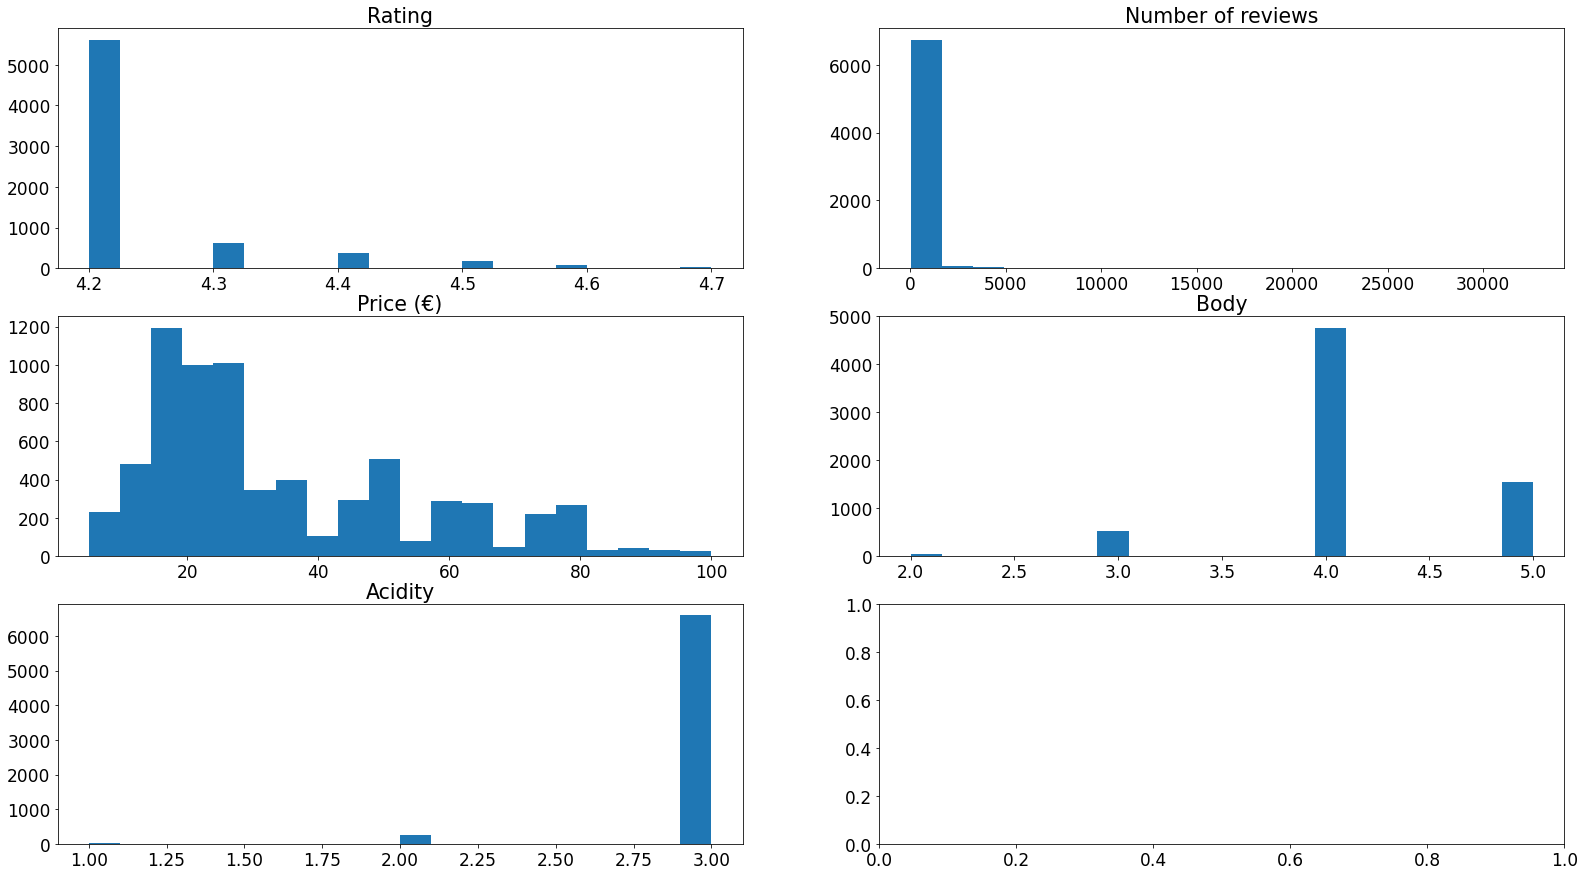

In [11]:
plt.rcParams.update({'font.size': 17})
fig, axs = plt.subplots(3,2,figsize=(27,15))
axs[0,0].hist(spanishWines['rating'],bins=20)
axs[0,0].set_title('Rating')
axs[0,1].hist(spanishWines['num_reviews'],bins=20)
axs[0,1].set_title('Number of reviews')
axs[1,0].hist(spanishWines['price'],bins=20)
axs[1,0].set_title('Price (€)')
axs[1,1].hist(spanishWines['body'],bins=20)
axs[1,1].set_title('Body')
axs[2,0].hist(spanishWines['acidity'],bins=20)
axs[2,0].set_title('Acidity')

To examine whether the data meet the assumptions of linear regression and to get an idea about how the linear model tends to perform in this situation, I ran an ordinary least squares regression and plotted the residuals against the model's predictions.

In [12]:
def residualsPlot(model,predictionSet,targetSet):
    fig = plt.figure()
    plt.rcParams.update({'font.size': 8})
    predictedValues = model.predict(predictionSet)
    plt.scatter(predictedValues,predictedValues-targetSet,label='Residual Plot') 
    plt.xlabel('Predicted Y')
    plt.ylabel('Residuals')

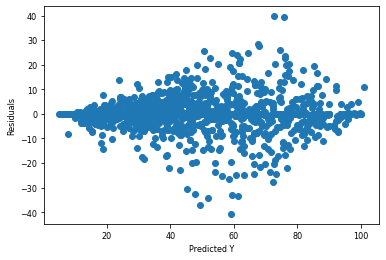

In [13]:
residualsModel = linear_model.LinearRegression(fit_intercept=True) 
residualsModel.fit(spanishWines.drop('price',axis=1),spanishWines['price'])

residualsPlot(residualsModel,spanishWines.drop('price',axis=1),spanishWines['price'])

We see that linearity and normality are satisfied. There is a small degree of heteroscedasticity and the model seems to be producing large errors for a relatively small amount of wines, but I judged this to be acceptable.

I then split the dataset in train and test sets. Although I employed the ```LassoCV``` (see below) which performs 5-fold cross validation as a means to tune the Lasso hyperparameter, I still needed a seperate test set to avoid data leakage due to the standardization processes.

Next I standardized the feature variables and centered the target variable so as to render the data suitable for Lasso regression.

In [14]:
featureTrain, featureTest, targetTrain, targetTest = train_test_split(spanishWines.drop(['price'],axis=1),
                                                                      spanishWines['price'], 
                                                                      test_size=0.25,random_state=42)

featureTrainStd = featureTrain.copy()
featureScaler = StandardScaler(with_mean=True, with_std=True)
featureTrainStd[['rating','num_reviews','body','acidity']] = featureScaler.fit_transform(
                                                             featureTrain[['rating','num_reviews','body','acidity']])
featureTrainStd = featureTrainStd.to_numpy()

targetTrain2d = targetTrain.to_numpy().reshape(-1, 1)
targetScaler = StandardScaler(with_mean=True,with_std=False)
targetTrainCentered = targetScaler.fit_transform(targetTrain2d)

Finally I created a Lasso model with Scikit's ```LassoCV```. ```LassoCV``` performs by default a 5-fold cross-valdation across a range of possible Lasso hyperparameter values  (called ```alphas``` in this setting) and automatically picks the optimal hyperparameter. The range of ```alphas``` that I chose for this model was from 0.01 to 0.99 with a step of 0.01.

In [15]:
lassoModel = LassoCV(alphas=np.arange(0.01,1,0.01),fit_intercept=True,random_state=7)
lassoModel.fit(featureTrainStd,np.ravel(targetTrainCentered))

LassoCV(alphas=array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]),
        random_state=7)

In [16]:
featureTestStd = featureTest.copy()
featureTestStd[['rating','num_reviews','body','acidity']] = featureScaler.transform(
                                                             featureTest[['rating','num_reviews','body','acidity']])
featureTestStd = featureTestStd.to_numpy()

targetTest2d = targetTest.to_numpy().reshape(-1, 1)
targetTestCentered = targetScaler.transform(targetTest2d)

testPredictions = lassoModel.predict(featureTestStd)
testMSE = mean_squared_error(targetTestCentered,testPredictions)

print('**Test set prediction metrics**')
print('Mean Squared Error: %.2f'%(testMSE))
testRMSE = np.sqrt(testMSE)
print('Root of Mean Squared Error: %.2f'%(testRMSE))

**Test set prediction metrics**
Mean Squared Error: 49.79
Root of Mean Squared Error: 7.06


After the completion of the training of the model I performed the prediction of targets based on the test set. The root of the Mean Squared Error of this process was at 7.06€ and thus the model exhibits low to moderate error.